In [163]:
import os
import pdb
from enum import Enum, auto
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics, svm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, make_scorer, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from speechbrain.processing.PLDA_LDA import *
from xgboost import XGBClassifier

In [164]:
class MyEnum(Enum):
    ITALIAN = auto()
    MDVR = auto()
    AH = auto()
    CZECH = auto()

class Extractor(Enum):
    XVECTOR = auto()
    TRILLSSON = auto()
    WAV2Vec = auto()
    HUBERT = auto()
    

selected_dataset = MyEnum.ITALIAN
selected_extractor = Extractor.TRILLSSON

In [165]:
if selected_dataset == MyEnum.ITALIAN:
    dataset = "Italian"
elif selected_dataset == MyEnum.MDVR:
    dataset = "MDVR"
elif selected_dataset == MyEnum.AH:
    dataset = "AH"
elif selected_dataset == MyEnum.CZECH:
    dataset = "Czech"
# Save the trained model to a file

if selected_extractor == Extractor.XVECTOR :
    extractor_number = 0
    extractor = "xvector"
if selected_extractor == Extractor.TRILLSSON :
    extractor_number = 1
    extractor = "trillsson"
if selected_extractor == Extractor.WAV2Vec :
    extractor_number = 2
    extractor = "wav2vec"
if selected_extractor == Extractor.HUBERT :
    extractor_number = 3
    extractor = "hubert"

In [166]:
common_path = "../data/non_interpretable_features/"

hc_features_file = os.path.join(common_path, dataset+str(extractor_number)+"_hc_features.pkl" )
pd_features_file = os.path.join(common_path, dataset+str(extractor_number)+"_pd_features.pkl")

In [167]:
def predicted_vs_actual_table(model, X_test, y_test, model_type = None):
    # Predict probabilities on the test data
    y_predict_proba = model.predict_proba(X_test)

    # y_predict_prob is an array where each row contains the probability estimates for each class
    # Assuming you are interested in the probability of the positive class (class 1)
    positive_class_prob = y_predict_proba[:, 1]

    # Create a DataFrame to compare each individual predicted probability to the real value
    comparison_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted_Probability': positive_class_prob,
        'Predicted_Class': model.predict(X_test)
    })
    if model_type == None:
        comparison_df.Name = type(model).__name__
    else:
        comparison_df.Name = model_type.__name__

    # Print or use the DataFrame as needed
    pd.set_option('display.max_rows', 50)
    return comparison_df




def predicted_vs_actual_plot(comparison_df):

    # Sort the DataFrame by the 'Actual' column
    model_name = comparison_df.Name
    sorted_df = comparison_df.sort_values(by='Actual')

    # Scatter plot of Actual vs Predicted Probability
    plt.figure(figsize=(10, 7))
    plt.scatter(range(len(sorted_df)), sorted_df['Actual'], label='Actual', color='blue', alpha=0.7)
    plt.scatter(range(len(sorted_df)), sorted_df['Predicted_Probability'], label='Predicted Probability', color='red', alpha=0.7)

    # Draw a horizontal line at y=0.5
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

    plt.xlabel('Data Point (Index)')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted Probability ' + model_name)
    plt.legend()
    plt.show()

In [168]:
#save values to final table

final_results_df = pd.DataFrame(columns=('accuracy', 'precision', 'recall', 'f1-score'))

def save_metrics_finalDf(name, y_test, y_predict):
    final_accuracy = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['accuracy'],2)
    final_precision = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['precision'],2)
    final_recall = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['recall'],2)
    final_f1score = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['f1-score'],2)
    final_results_df.loc[name] = [final_accuracy, final_precision, final_recall, final_f1score]

def save_model(model, model_name):
    
    
    dir = os.path.join("../data/models", dataset + "/non-interpretable/" +extractor +"/")
    Path(dir).mkdir(parents=True, exist_ok=True)

    model_filename = os.path.join(dir , model_name + '.joblib')
    joblib.dump(model, model_filename)



In [169]:
class PCA_PLDA_EER_Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, PCA_n=5, eer_threshold=0.5, scaler=None, pca=None, plda=None, en_stat=None, en_sets=None, normalize=1):
        self.scaler = scaler   # for normalization
        self.PCA_n = PCA_n     # for PCA
        self.pca = pca         # for PCA
        self.plda = plda       # for plda
        self.en_stat = en_stat # for plda
        self.en_sets = en_sets # for plda
        self.eer_threshold = eer_threshold # for final classification
        self.normalize = normalize # 1 or 0, don't normalize if input feats are pre-normalized
        
    def fit(self, features_train, train_lbs):
        """
        features_train: np array [N x feature dim]
        train_lbs: a list of labels, 0 or 1
        """
        # PCA------------------------------------------------------------------------
        # Standardize features by removing the mean and scaling to unit variance
        if self.normalize == 1:
            self.scaler = StandardScaler()
            features_train = self.scaler.fit_transform(features_train) # Nx512



        self.pca = PCA(n_components=self.PCA_n)
        features_train = self.pca.fit_transform(features_train)    # NxPCA_n

        
        # speechbrain PLDA--------------------------------------------------------------
        train_lbs_tmp = np.array(train_lbs)
        features_PD = features_train[np.where(train_lbs_tmp == 0)[0]] # NxPCA_n
        features_HC = features_train[np.where(train_lbs_tmp == 1)[0]] # NxPCA_n

        # Set the 'classes_' attribute
        self.classes_ = np.unique(train_lbs)


        # PLDA
        dim, N = self.PCA_n, features_train.shape[0]
        train_xv = features_train
        md = ['md'+str(train_lbs[i]) for i in range(N)]
        modelset = numpy.array(md, dtype="|O")
        sg = ['sg'+str(i) for i in range(N)]
        segset = numpy.array(sg, dtype="|O")
        s = numpy.array([None] * N)
        stat0 = numpy.array([[1.0]]* N)
        xvectors_stat = StatObject_SB(modelset=modelset, segset=segset, start=s, stop=s, stat0=stat0, stat1=train_xv)
        # Training PLDA model: M ~ (mean, F, Sigma)
        self.plda = PLDA(rank_f=dim)
        self.plda.plda(xvectors_stat)

        # PLDA Enrollment (2 classes)
        en_N = 2
        en_pd = np.mean(features_PD, axis=0)
        en_hc = np.mean(features_HC, axis=0)
        en_xv = np.vstack((en_pd, en_hc))
        en_sgs = ['en'+str(i) for i in range(en_N)]
        self.en_sets = numpy.array(en_sgs, dtype="|O")
        en_s = numpy.array([None] * en_N)
        en_stat0 = numpy.array([[1.0]]* en_N)
        self.en_stat = StatObject_SB(modelset=self.en_sets, segset=self.en_sets, start=en_s, stop=en_s, stat0=en_stat0, stat1=en_xv)

        # get PLDA scores of train data for EER threshold
        va_N = features_train.shape[0]
        va_xv = features_train
        va_sgs = ['va'+str(i) for i in range(va_N)]
        va_sets = numpy.array(va_sgs, dtype="|O")
        va_s = numpy.array([None] * va_N)
        va_stat0 = numpy.array([[1.0]]* va_N)
        va_stat = StatObject_SB(modelset=va_sets, segset=va_sets, start=va_s, stop=va_s, stat0=va_stat0, stat1=va_xv)
        ndx = Ndx(models=self.en_sets, testsegs=va_sets)
        # PLDA Scoring
        scores_plda = fast_PLDA_scoring(self.en_stat, va_stat, ndx, self.plda.mean, self.plda.F, self.plda.Sigma)
        train_X = np.transpose(scores_plda.scoremat) # [#samples, 2]
        
        # get equal error rate threshold---------------------------------------------------
        train_pt = np.array([train_X[:,1]-train_X[:,0]]) #np.array([train_X[:,0]-train_X[:,1]])
        train_X = np.transpose(train_pt) # for eer

        fpr, tpr, threshold = roc_curve(train_lbs, train_X, pos_label=1, drop_intermediate=False)
        fnr = 1 - tpr
        self.eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        
    def predict_scores(self, features_test):
        """
        (for now apply only when N = 1 to make sure calling of fast_PLDA_scoring is on each test sample individually)

        features_test: np array [N x feature dim]
        
        return an array of predicted scores, np[1, N]
        """
        # PCA
        # Standardize features by removing the mean and scaling to unit variance
        if self.normalize == 1:
            features_test = self.scaler.transform(features_test) # Nx512
        # transform
        features_test = self.pca.transform(features_test)    # NxPCA_n
        
        # PLDA Test -------------------------------------------------------------------------------------------
        te_N = features_test.shape[0]
        te_xv = features_test
        te_sgs = ['te'+str(i) for i in range(te_N)]
        te_sets = numpy.array(te_sgs, dtype="|O")
        te_s = numpy.array([None] * te_N)
        te_stat0 = numpy.array([[1.0]]* te_N)
        te_stat = StatObject_SB(modelset=te_sets, segset=te_sets, start=te_s, stop=te_s, stat0=te_stat0, stat1=te_xv)
        ndx = Ndx(models=self.en_sets, testsegs=te_sets)
        # PLDA Scoring
        scores_plda = fast_PLDA_scoring(self.en_stat, te_stat, ndx, self.plda.mean, self.plda.F, self.plda.Sigma)
        scores_y = np.transpose(scores_plda.scoremat) # [#samples, 2]

        # Classification by plda scores with eer threshold ----------------------------------
        test_pt = np.array(scores_y[:,1]-scores_y[:,0]) # [N,]
        return test_pt
    
    def predict_scores_list(self, features_test):
        """
        features_test: np array [N x feature dim]
        
        return an array of predicted scores [N,1]
        """
        N = features_test.shape[0]
        scores = []
        for i in range(N):
            # check if feat vect contains nan vals,
            # set score as nan if yes
            if np.isnan(features_test[i,0]):
                scores.append(np.nan)
            else:
                scores.append(self.predict_scores(features_test[[i],:])[0])
        scores = np.array(scores)
        scores = scores[:,np.newaxis] # [N,] to [N,1]
        return scores

    def predict(self, features_test):
        """
        features_test: np array [N x feature dim]
        
        return a list of predicted labels, 0 or 1
        """
        predictions = []
        for i in range(features_test.shape[0]):
            test_pt = self.predict_scores(features_test[[i],:])
            if test_pt[0] > self.eer_threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        
        # test_pt = self.predict_scores(features_test)
        # predictions = list(test_pt[0]<self.eer_threshold) # > threshold pred 0, < threshold then 1
        # predictions = [int(x) for x in predictions]
        
        return predictions
    
    def predict_proba(self, features_test):
        """
        Calculate probability estimates for each class.

        features_test: np array [N x feature dim]

        return an array of predicted probabilities [N, 2], where each row is [probability_class_0, probability_class_1]
        """
        # PCA
        if self.normalize == 1:
            features_test = self.scaler.transform(features_test)

        features_test = self.pca.transform(features_test)

        # PLDA Test
        te_N = features_test.shape[0]
        te_xv = features_test
        te_sgs = ['te'+str(i) for i in range(te_N)]
        te_sets = numpy.array(te_sgs, dtype="|O")
        te_s = numpy.array([None] * te_N)
        te_stat0 = numpy.array([[1.0]]* te_N)
        te_stat = StatObject_SB(modelset=te_sets, segset=te_sets, start=te_s, stop=te_s, stat0=te_stat0, stat1=te_xv)
        ndx = Ndx(models=self.en_sets, testsegs=te_sets)

        # PLDA Scoring
        scores_plda = fast_PLDA_scoring(self.en_stat, te_stat, ndx, self.plda.mean, self.plda.F, self.plda.Sigma)
        scores_y = np.transpose(scores_plda.scoremat)  # [#samples, 2]

        # Softmax transformation to get probabilities
        exp_scores = np.exp(scores_y)
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return probabilities

In [170]:
with open(hc_features_file, 'rb') as f:
    hc_data = pickle.load(f)

with open(pd_features_file, 'rb') as f:
    pd_data = pickle.load(f)

# Extract features and labels from the dictionaries
hc_features = np.array([value[0] for value in hc_data.values()])
pd_features = np.array([value[0] for value in pd_data.values()])

# Assuming labels for healthy controls (0) and Parkinson's patients (1)
hc_labels = np.zeros(len(hc_features))
pd_labels = np.ones(len(pd_features))

all_features = np.vstack((hc_features, pd_features))
all_labels = np.concatenate((hc_labels, pd_labels))

scaler = StandardScaler()
all_features_normalized = scaler.fit_transform(all_features)




In [171]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features_normalized, all_labels, test_size=0.2, random_state=42)


# PCA PLDA EER

In [172]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'PCA_n': [5, 10, 15],
    'eer_threshold': [0.5, 0.6, 0.7]
}

# Instantiate the classifier
#normalization was already applied
classifier = PCA_PLDA_EER_Classifier(normalize=0)

# Define a scoring function (you might want to use a different metric based on your problem)
scoring = make_scorer(roc_auc_score)

# Instantiate GridSearchCV
plda_model = GridSearchCV(classifier, param_grid, scoring=scoring, cv=5)

# Fit the model with hyperparameter tuning
plda_model.fit(X_train, y_train)

# Print the best hyperparameters and corresponding ROC AUC score
print("Best Hyperparameters:", plda_model.best_params_)
print("Best ROC AUC Score:", plda_model.best_score_)

# Test the classifier on the test set
plda_predictions = plda_model.predict(X_test)

# Evaluate the performance on the test set
test_accuracy = accuracy_score(y_test, plda_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Best Hyperparameters: {'PCA_n': 15, 'eer_threshold': 0.6}
Best ROC AUC Score: 0.8184665987607165
Test Accuracy: 78.79%


In [173]:
save_metrics_finalDf('PLDA (HPT)', y_test, plda_predictions)
save_model(plda_model, 'plda')

Confusion Matrix - PLDA Classifier
Classification Report - PLDA Classifier
              precision    recall  f1-score   support

           1       0.83      0.75      0.79        53
           0       0.75      0.83      0.78        46

    accuracy                           0.79        99
   macro avg       0.79      0.79      0.79        99
weighted avg       0.79      0.79      0.79        99



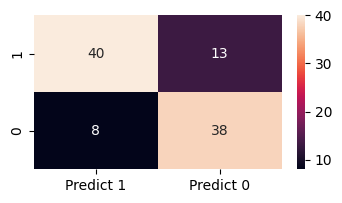

In [174]:
print("Confusion Matrix - PLDA Classifier")
cm = confusion_matrix(y_test, plda_predictions, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4,2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - PLDA Classifier")
print(classification_report(y_test, plda_predictions, labels=[1, 0]))


    Actual  Predicted_Probability  Predicted_Class
0      1.0               0.665508                1
1      0.0               0.309494                0
2      1.0               0.341838                1
3      0.0               0.586434                0
4      1.0               0.327990                1
..     ...                    ...              ...
94     0.0               0.361823                0
95     1.0               0.627336                1
96     1.0               0.516105                0
97     0.0               0.349483                0
98     1.0               0.605446                1

[99 rows x 3 columns]


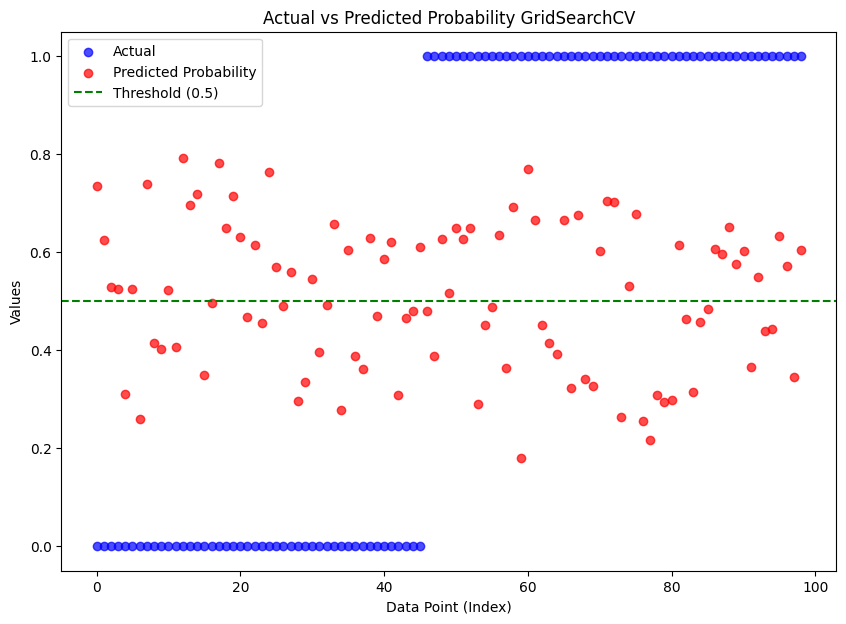

In [175]:
table_plda = predicted_vs_actual_table(plda_model, X_test, y_test)
print(table_plda)
predicted_vs_actual_plot(table_plda)

# Logistic Regression with Hyperparameter tuning

In [176]:
# List Hyperparameters that we want to tune.


solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Convert to dictionary
hyperparameters = dict(solver=solvers, penalty=penalty, C=c_values)

# Create new LR object
model_lr_2 = LogisticRegression(max_iter=1000)

# Create RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform k-fold cross-validation
cv_results = cross_val_score(model_lr_2, X_train, y_train, cv=cv, scoring='accuracy')

# Print the results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Use GridSearch
clf = GridSearchCV(model_lr_2, hyperparameters, cv=cv)

# Fit the model
plda_model = clf.fit(X_train, y_train)

# Print the value of best hyperparameters
print('Best Score: %s' % plda_model.best_score_)
print('Best Hyperparameters: %s' % plda_model.best_params_)

y_pred_lr_2 = plda_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_lr_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0, 0] + conf_matrix_knn_2[1, 1]) / (conf_matrix_knn_2[0, 0] + conf_matrix_knn_2[0, 1] + conf_matrix_knn_2[1, 0] + conf_matrix_knn_2[1, 1])) * 100

Cross-Validation Accuracy: 97.306% (± 2.343%)
Best Score: 0.9806623931623932
Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [177]:
pd.set_option('display.max_rows', None)
table_lr_2 = predicted_vs_actual_table(plda_model, X_test, y_test, type(model_lr_2))


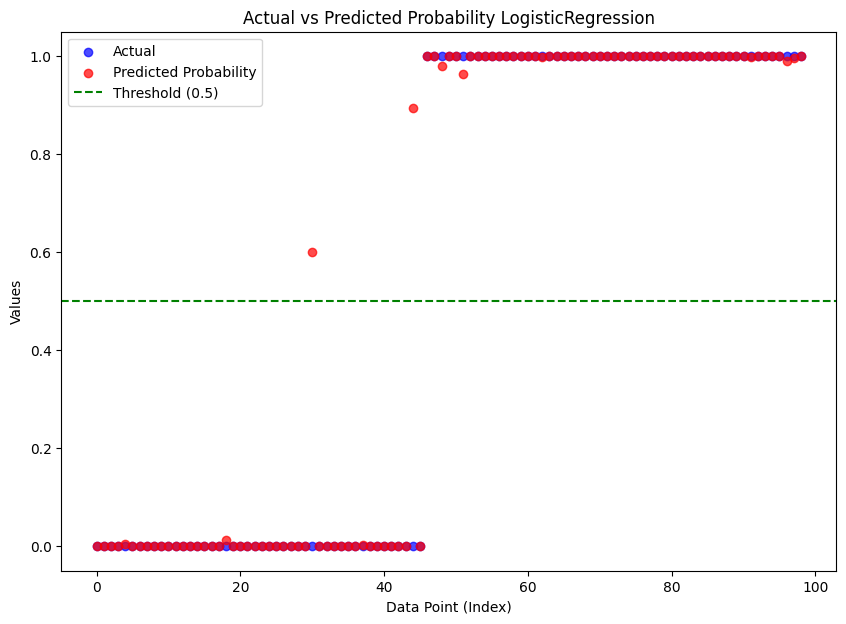

In [178]:
pva_plot_lr_2 = predicted_vs_actual_plot(table_lr_2)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        46
         1.0       0.96      1.00      0.98        53

    accuracy                           0.98        99
   macro avg       0.98      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99



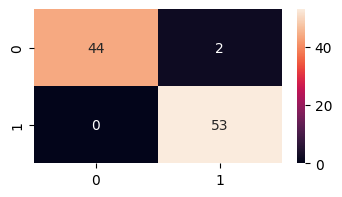

In [179]:

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)


#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_lr_2))
#Checking performance our model with ROC Score.

save_metrics_finalDf('Logistic Regression (HPT)', y_test, y_pred_lr_2)
save_model(plda_model, 'lr_2')

# KNN with hyperparameter tuning

In [180]:
# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 20)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Create a KNeighborsClassifier
model_knn_2 = KNeighborsClassifier()

# Create GridSearchCV
clf = GridSearchCV(model_knn_2, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
clf.fit(X_train, np.ravel(y_train, order='C'))

# Get the best parameters
best_params = clf.best_params_

# Get the best model
best_model_knn_2 = clf.best_estimator_

# Evaluate the best model using k-fold cross-validation
cv_results = cross_val_score(best_model_knn_2, X_train, np.ravel(y_train, order='C'), cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Evaluate the best model on the test set
y_pred_knn_2 = best_model_knn_2.predict(X_test)
model_score_knn = best_model_knn_2.score(X_test, y_test)

# Print the results
print('Best Hyperparameters:', best_params)
print('Best Model Score:', model_score_knn)

Cross-Validation Accuracy: 84.342% (± 2.067%)
Best Hyperparameters: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best Model Score: 0.797979797979798


In [181]:
table_knn_2 = predicted_vs_actual_table(best_model_knn_2, X_test, y_test, type(model_knn_2))
print(table_knn_2)

    Actual  Predicted_Probability  Predicted_Class
0      1.0               0.695381              1.0
1      0.0               0.690999              1.0
2      1.0               0.628299              1.0
3      0.0               0.212869              0.0
4      1.0               0.523907              1.0
..     ...                    ...              ...
94     0.0               0.386529              0.0
95     1.0               0.753070              1.0
96     1.0               0.495721              0.0
97     0.0               0.292453              0.0
98     1.0               0.399529              0.0

[99 rows x 3 columns]


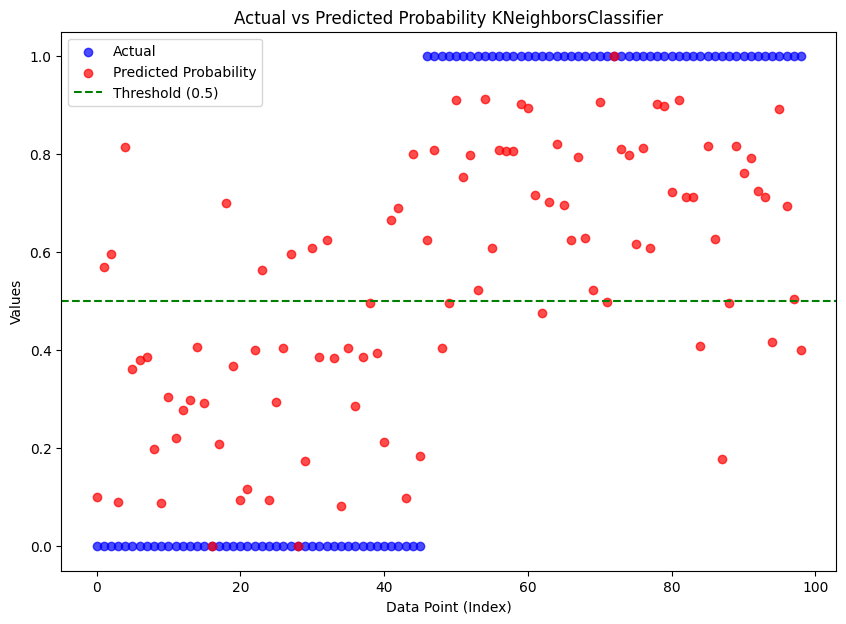

In [182]:
predicted_vs_actual_plot(table_knn_2)

79.7979797979798
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78        46
         1.0       0.80      0.83      0.81        53

    accuracy                           0.80        99
   macro avg       0.80      0.80      0.80        99
weighted avg       0.80      0.80      0.80        99



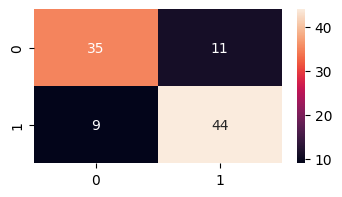

In [183]:

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)

save_metrics_finalDf('KNN (HPT)', y_test, y_pred_knn_2)
save_model(best_model_knn_2, 'knn_2')

# Naive Bayes

In [184]:
model_nb = GaussianNB()

# Perform k-fold cross-validation
cv_results = cross_val_score(model_nb, X_train, np.ravel(y_train, order='C'), cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Fit the model to the training data
model_nb.fit(X_train, np.ravel(y_train, order='C'))

# Make predictions on the test set
y_predict_nb = model_nb.predict(X_test)

# Evaluate the model on the test set
model_score_nb = metrics.accuracy_score(y_test, y_predict_nb)

# Print the results
print('Model Score:', model_score_nb)

Cross-Validation Accuracy: 73.503% (± 5.829%)
Model Score: 0.6767676767676768


In [185]:
table_nb = predicted_vs_actual_table(model_nb, X_test, y_test)
table_nb.Name = type(GaussianNB()).__name__
print(table_nb)

    Actual  Predicted_Probability  Predicted_Class
0      1.0           3.557224e-28              0.0
1      0.0           1.000000e+00              1.0
2      1.0           1.000000e+00              1.0
3      0.0           3.703575e-34              0.0
4      1.0           4.769822e-03              0.0
..     ...                    ...              ...
94     0.0           4.361071e-21              0.0
95     1.0           1.000000e+00              1.0
96     1.0           1.796111e-50              0.0
97     0.0           3.760809e-23              0.0
98     1.0           4.240276e-03              0.0

[99 rows x 3 columns]


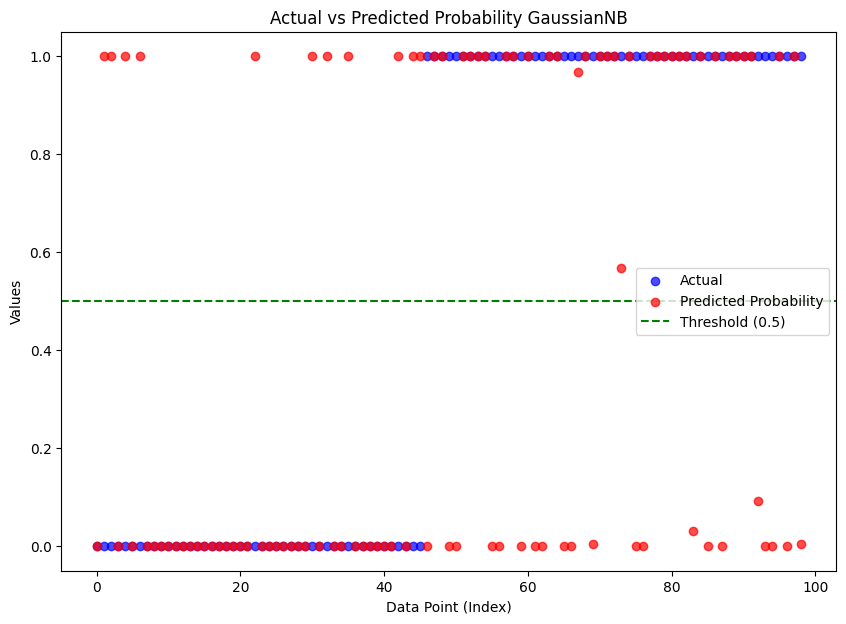

In [186]:
predicted_vs_actual_plot(table_nb)

Confusion Matrix - Naive Bayes
Classification Report - Naive Bayes
              precision    recall  f1-score   support

           1       0.74      0.60      0.67        53
           0       0.62      0.76      0.69        46

    accuracy                           0.68        99
   macro avg       0.68      0.68      0.68        99
weighted avg       0.69      0.68      0.68        99



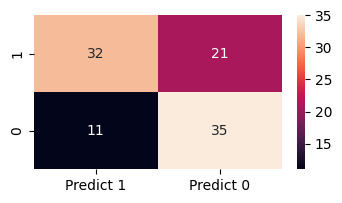

In [187]:
print("Confusion Matrix - Naive Bayes")
cm=metrics.confusion_matrix(y_test, y_predict_nb, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - Naive Bayes")
print(metrics.classification_report(y_test, y_predict_nb, labels=[1, 0]))

save_metrics_finalDf('NB', y_test, y_predict_nb)
save_model(model_nb, 'nb')

# SVM with hyperparameter tuning

In [188]:
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

# Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)

# Create new SVM object
model_svm_2 = svm.SVC(probability=True)

# Create RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Use GridSearchCV
clf = GridSearchCV(model_svm_2, hyperparameters, refit=True, cv=cv)

# Fit the model
best_model_svm_2 = clf.fit(X_train, y_train)

# Print the value of best hyperparameters
print('Best Score: %s' % best_model_svm_2.best_score_)
print('Best Hyperparameters: %s' % best_model_svm_2.best_params_)
print(hyperparameters)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(best_model_svm_2.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Make predictions on the test set
y_pred_svm_2 = best_model_svm_2.predict(X_test)

# Evaluate the model on the test set
conf_matrix_svm_2 = confusion_matrix(y_test, y_pred_svm_2)
accuracy_svm_2 = ((conf_matrix_svm_2[0,0] + conf_matrix_svm_2[1,1]) / (conf_matrix_svm_2[0,0] + conf_matrix_svm_2[0,1] + conf_matrix_svm_2[1,0] + conf_matrix_svm_2[1,1])) * 100

# Print the results
print('Model Score:', accuracy_svm_2)

Best Score: 0.9755982905982905
Best Hyperparameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
Cross-Validation Accuracy: 97.560% (± 2.869%)
Model Score: 98.98989898989899


In [189]:
table_svm_2 = predicted_vs_actual_table(plda_model, X_test, y_test, type(model_svm_2))
print(table_svm_2)

    Actual  Predicted_Probability  Predicted_Class
0      1.0           9.999992e-01              1.0
1      0.0           1.324734e-09              0.0
2      1.0           9.999710e-01              1.0
3      0.0           3.703701e-06              0.0
4      1.0           9.999693e-01              1.0
..     ...                    ...              ...
94     0.0           2.348481e-03              0.0
95     1.0           9.632874e-01              1.0
96     1.0           9.999932e-01              1.0
97     0.0           1.232601e-06              0.0
98     1.0           9.999977e-01              1.0

[99 rows x 3 columns]


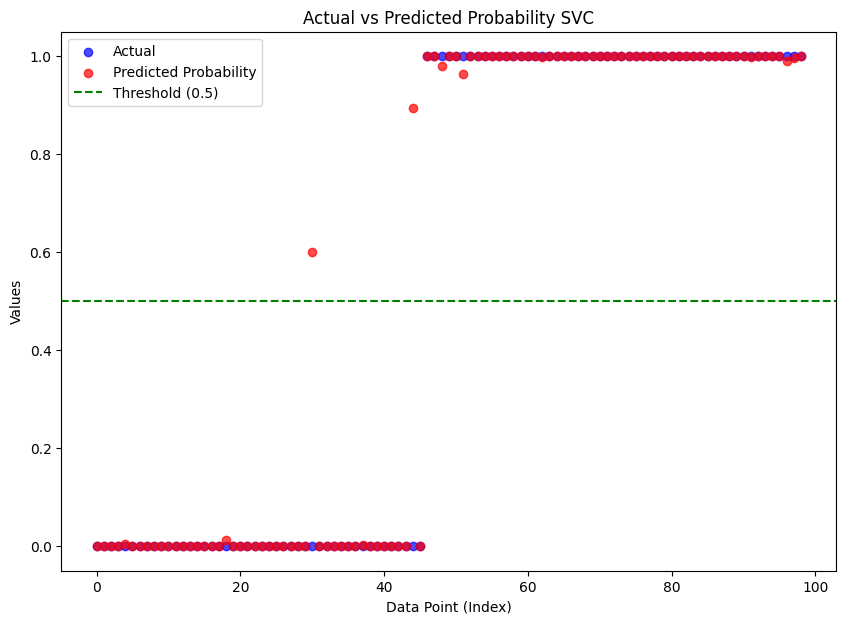

In [190]:
predicted_vs_actual_plot(table_svm_2)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        46
         1.0       1.00      0.98      0.99        53

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99



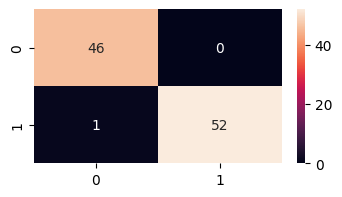

In [191]:
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_svm_2))
#Checking performance our model with ROC Score.


plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_svm_2, annot=True)

save_metrics_finalDf('SVM (HPT)', y_test, y_pred_svm_2)
save_model(best_model_svm_2, 'svm_2')

# Random Forest with Hyperparameter Tuning

In [192]:
# Define the RandomForestClassifier with default parameters
model_rf = RandomForestClassifier(random_state=1)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees in the forest
    'max_features': [3, 5, 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
}

# Create GridSearchCV
grid_search_rf = GridSearchCV(model_rf, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_

# Print the best parameters
print("Best Hyperparameters for Random Forest:", best_params_rf)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Use the best model for predictions
best_model_rf = grid_search_rf.best_estimator_
y_predict_rf = best_model_rf.predict(X_test)

Best Hyperparameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150}
Cross-Validation Accuracy: 86.370% (± 2.409%)


In [193]:
table_rf = predicted_vs_actual_table(best_model_rf, X_test, y_test)
print(table_rf)

    Actual  Predicted_Probability  Predicted_Class
0      1.0               0.686667              1.0
1      0.0               0.646667              1.0
2      1.0               0.833333              1.0
3      0.0               0.380000              0.0
4      1.0               0.720000              1.0
..     ...                    ...              ...
94     0.0               0.353333              0.0
95     1.0               0.846667              1.0
96     1.0               0.426667              0.0
97     0.0               0.366667              0.0
98     1.0               0.573333              1.0

[99 rows x 3 columns]


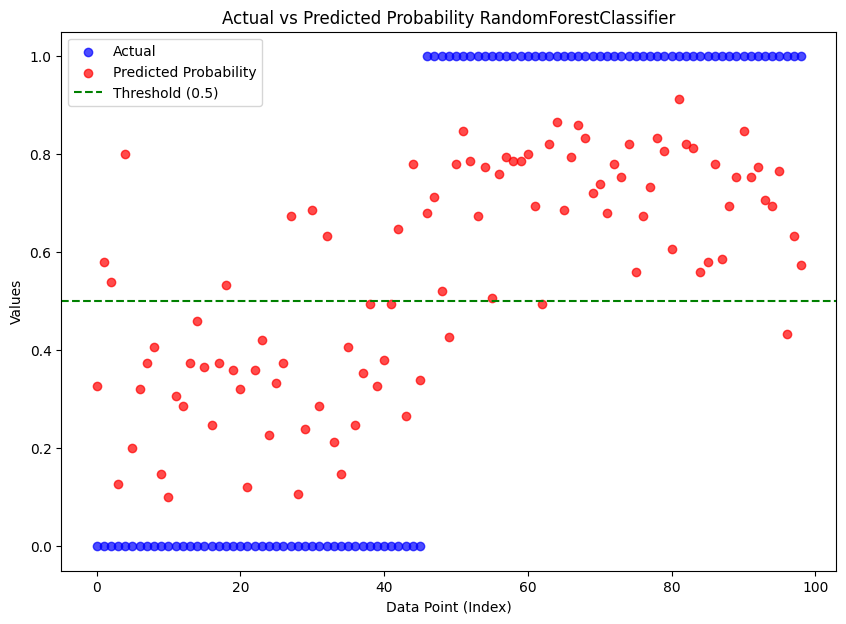

In [194]:
predicted_vs_actual_plot(table_rf)

Confusion Matrix -Random Forest


<Axes: >

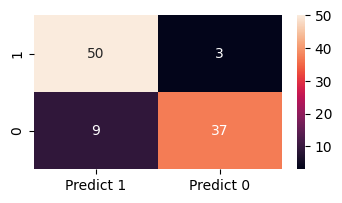

In [195]:
print("Confusion Matrix -Random Forest")
cm=metrics.confusion_matrix(y_test, y_predict_rf, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [196]:
print("Classification Report - Random Forest")
print(metrics.classification_report(y_test, y_predict_rf, labels=[1, 0]))

Classification Report - Random Forest
              precision    recall  f1-score   support

           1       0.85      0.94      0.89        53
           0       0.93      0.80      0.86        46

    accuracy                           0.88        99
   macro avg       0.89      0.87      0.88        99
weighted avg       0.88      0.88      0.88        99



In [197]:
# Save metrics and model
save_metrics_finalDf('Random Forest (HPT)', y_test, y_predict_rf)
save_model(best_model_rf, 'rf_2')

# Bagging with Hyperparameter Tuning

In [198]:
model_bgcl_2 = BaggingClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Create GridSearchCV
grid_search_bgcl = GridSearchCV(model_bgcl_2, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_bgcl.fit(X_train, y_train)

# Get the best hyperparameters
best_params_bgcl = grid_search_bgcl.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for Bagging Classifier:", best_params_bgcl)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_bgcl.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Get the best Bagging Classifier model
best_model_bgcl_2 = grid_search_bgcl.best_estimator_

# Fit the best model on the training data
best_model_bgcl_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_bag_2 = best_model_bgcl_2.predict(X_test)

Best Hyperparameters for Bagging Classifier: {'n_estimators': 30}
Cross-Validation Accuracy: 84.854% (± 1.306%)


In [199]:
table_bgcl_2 = predicted_vs_actual_table(best_model_bgcl_2, X_test, y_test, type(model_bgcl_2))
print(table_bgcl_2)

    Actual  Predicted_Probability  Predicted_Class
0      1.0               0.766667              1.0
1      0.0               0.433333              0.0
2      1.0               0.900000              1.0
3      0.0               0.266667              0.0
4      1.0               1.000000              1.0
..     ...                    ...              ...
94     0.0               0.333333              0.0
95     1.0               0.900000              1.0
96     1.0               0.600000              1.0
97     0.0               0.133333              0.0
98     1.0               0.600000              1.0

[99 rows x 3 columns]


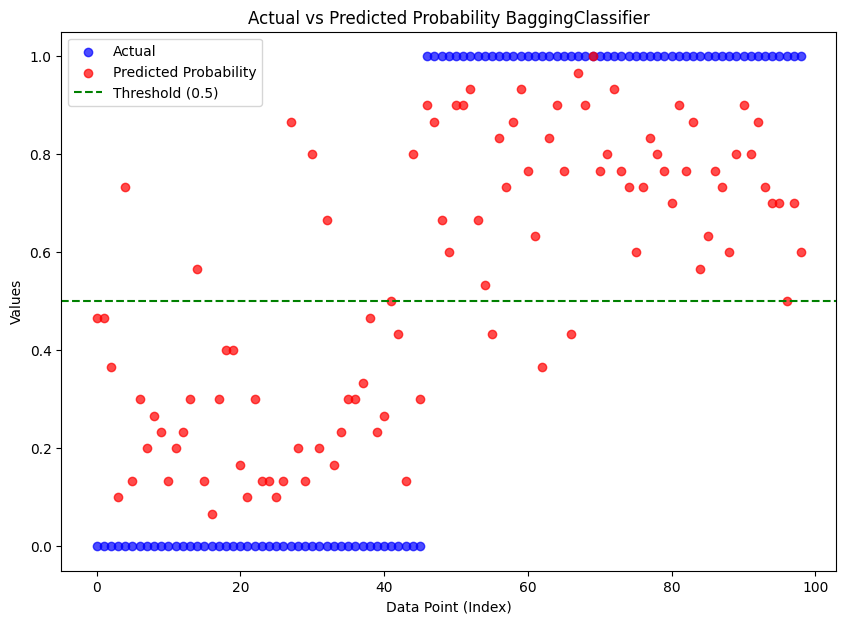

In [200]:
predicted_vs_actual_plot(table_bgcl_2)

Confusion Matrix - Bagging Classifier
Classification Report - Bagging Classifier
              precision    recall  f1-score   support

           1       0.89      0.92      0.91        53
           0       0.91      0.87      0.89        46

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.90      0.90      0.90        99



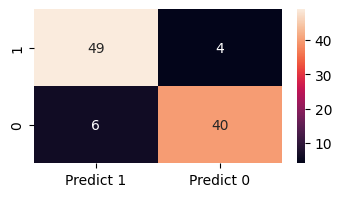

In [201]:

# Compute and print the confusion matrix
print("Confusion Matrix - Bagging Classifier")
cm = confusion_matrix(y_test, y_predict_bag_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Bagging Classifier")
print(classification_report(y_test, y_predict_bag_2, labels=[1, 0]))

save_metrics_finalDf('Bagging (HPT)', y_test, y_predict_bag_2)
save_model(best_model_bgcl_2, 'bgcl_2')


# AdaBoost with Hyperparameter Tuning

In [202]:
model_adabc_2 = AdaBoostClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Create GridSearchCV
grid_search_adabc = GridSearchCV(model_adabc_2, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_adabc.fit(X_train, y_train)

# Get the best hyperparameters
best_params_adabc = grid_search_adabc.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for AdaBoost Classifier:", best_params_adabc)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_adabc.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Get the best AdaBoost Classifier model
best_model_adabc_2 = grid_search_adabc.best_estimator_

# Fit the best model on the training data
best_model_adabc_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_ada_2 = best_model_adabc_2.predict(X_test)

Best Hyperparameters for AdaBoost Classifier: {'n_estimators': 50}
Cross-Validation Accuracy: 87.123% (± 3.864%)


In [203]:
table_adabc_2 = predicted_vs_actual_table(best_model_adabc_2, X_test, y_test, type(model_adabc_2))
print(table_adabc_2)

    Actual  Predicted_Probability  Predicted_Class
0      1.0               0.524924              1.0
1      0.0               0.511598              1.0
2      1.0               0.577213              1.0
3      0.0               0.500267              1.0
4      1.0               0.503583              1.0
..     ...                    ...              ...
94     0.0               0.465292              0.0
95     1.0               0.549704              1.0
96     1.0               0.517888              1.0
97     0.0               0.472615              0.0
98     1.0               0.533547              1.0

[99 rows x 3 columns]


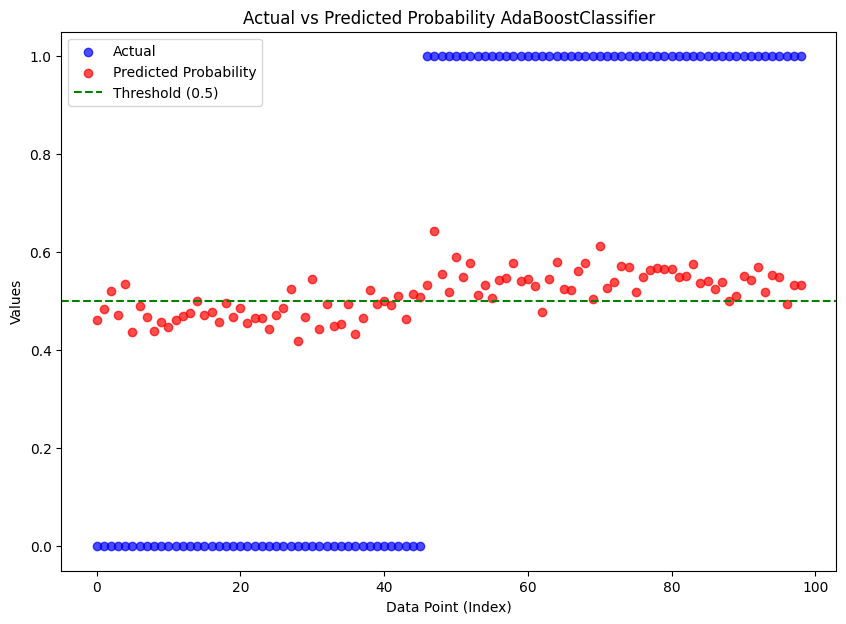

In [204]:
predicted_vs_actual_plot(table_adabc_2)

Confusion Matrix - Ada Boost
Classification Report - Ada Boost
              precision    recall  f1-score   support

           1       0.83      0.94      0.88        53
           0       0.92      0.78      0.85        46

    accuracy                           0.87        99
   macro avg       0.88      0.86      0.87        99
weighted avg       0.88      0.87      0.87        99



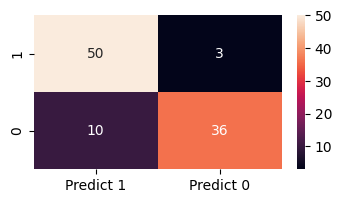

In [205]:

# Compute and print the confusion matrix
print("Confusion Matrix - Ada Boost")
cm = confusion_matrix(y_test, y_predict_ada_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Ada Boost")
print(classification_report(y_test, y_predict_ada_2, labels=[1, 0]))

save_metrics_finalDf('AdaBoost (HPT)', y_test, y_predict_ada_2)
save_model(best_model_adabc_2, 'adabc_2')


# XGBoost with Hyperparameter tuning

In [206]:
model_xgbc_2 = XGBClassifier(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate
    'n_estimators': [50, 100, 200],  # Adjust the number of estimators
    'max_depth': [3, 4, 5]  # Adjust the maximum depth of trees
    # You can add more hyperparameters to tune here
}

# Create GridSearchCV
grid_search_xgbc = GridSearchCV(model_xgbc_2, param_grid, cv=5, scoring='accuracy')

# Fit the model with hyperparameter tuning
grid_search_xgbc.fit(X_train, y_train)

# Get the best hyperparameters
best_params_xgbc = grid_search_xgbc.best_params_

# Print the best hyperparameters
print("Best Hyperparameters for XGBClassifier:", best_params_xgbc)

# Perform k-fold cross-validation on the best model
cv_results = cross_val_score(grid_search_xgbc.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation results
print('Cross-Validation Accuracy: %.3f%% (± %.3f%%)' % (np.mean(cv_results)*100, np.std(cv_results)*100))

# Get the best XGBClassifier model
best_model_xgbc_2 = grid_search_xgbc.best_estimator_

# Fit the best model on the training data
best_model_xgbc_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_XGB_2 = best_model_xgbc_2.predict(X_test)

Best Hyperparameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Cross-Validation Accuracy: 90.661% (± 3.528%)


In [207]:
table_xgbc_2 = predicted_vs_actual_table(best_model_xgbc_2, X_test, y_test)
print(table_xgbc_2)

    Actual  Predicted_Probability  Predicted_Class
0      1.0               0.998151                1
1      0.0               0.361812                0
2      1.0               0.996662                1
3      0.0               0.012129                0
4      1.0               0.979280                1
..     ...                    ...              ...
94     0.0               0.009103                0
95     1.0               0.986407                1
96     1.0               0.823431                1
97     0.0               0.068175                0
98     1.0               0.725804                1

[99 rows x 3 columns]


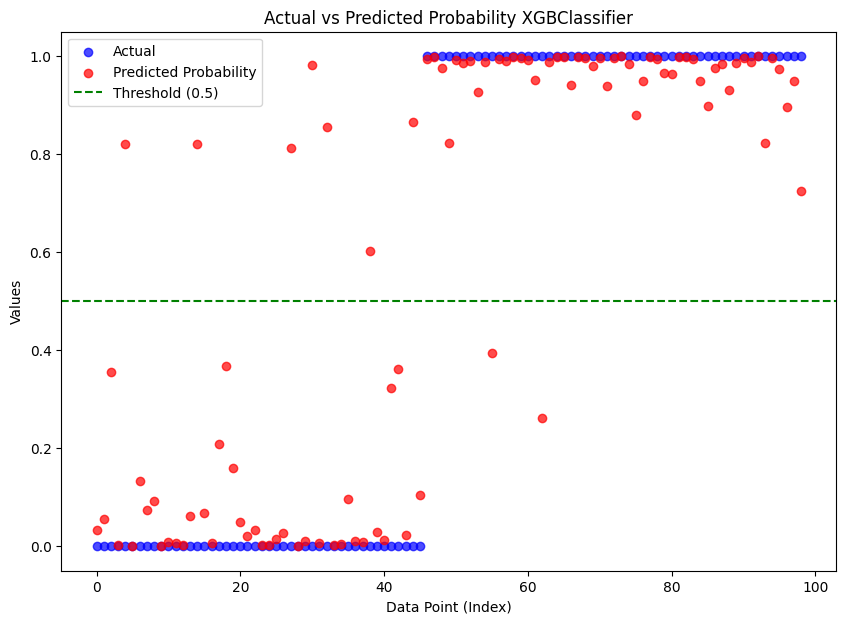

In [208]:
predicted_vs_actual_plot(table_xgbc_2)

Confusion Matrix - XGB Classifier
Classification Report - XGB Classifier
              precision    recall  f1-score   support

           1       0.88      0.96      0.92        53
           0       0.95      0.85      0.90        46

    accuracy                           0.91        99
   macro avg       0.92      0.91      0.91        99
weighted avg       0.91      0.91      0.91        99



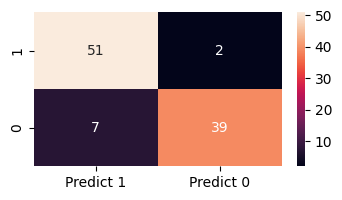

In [209]:
# Compute and print the confusion matrix
print("Confusion Matrix - XGB Classifier")
cm = confusion_matrix(y_test, y_predict_XGB_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4,2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - XGB Classifier")
print(classification_report(y_test, y_predict_XGB_2, labels=[1, 0]))


save_metrics_finalDf('XGBoost (HPT)', y_test, y_predict_XGB_2)
save_model(best_model_xgbc_2, 'xgbc_2')


# Voting Classificator

In [210]:
estimators = estimators=[('LR', plda_model), ('KNN', best_model_knn_2), ('NB', model_nb), ('SVM', best_model_svm_2), ('RF', best_model_rf), ('BG', best_model_bgcl_2), ('ADA', best_model_adabc_2), ('XGB', best_model_xgbc_2)]

In [211]:
# Create a Voting Classifier (Soft Voting)


model_voting = VotingClassifier(estimators, voting='soft')
# Fit and evaluate the model
model_voting.fit(X_train, y_train)
accuracy_soft = model_voting.score(X_test, y_test)
print(f'Accuracy (Soft Voting): {accuracy_soft}')

# Make predictions on the test set
y_predict_voting_cl = model_voting.predict(X_test)

Accuracy (Soft Voting): 0.9595959595959596


In [212]:
table_clf_soft = predicted_vs_actual_table(model_voting, X_test, y_test)
print(table_clf_soft)

    Actual  Predicted_Probability  Predicted_Class
0      1.0               0.708974              1.0
1      0.0               0.458800              0.0
2      1.0               0.866309              1.0
3      0.0               0.171810              0.0
4      1.0               0.712953              1.0
..     ...                    ...              ...
94     0.0               0.198666              0.0
95     1.0               0.870510              1.0
96     1.0               0.607046              1.0
97     0.0               0.167060              0.0
98     1.0               0.603679              1.0

[99 rows x 3 columns]


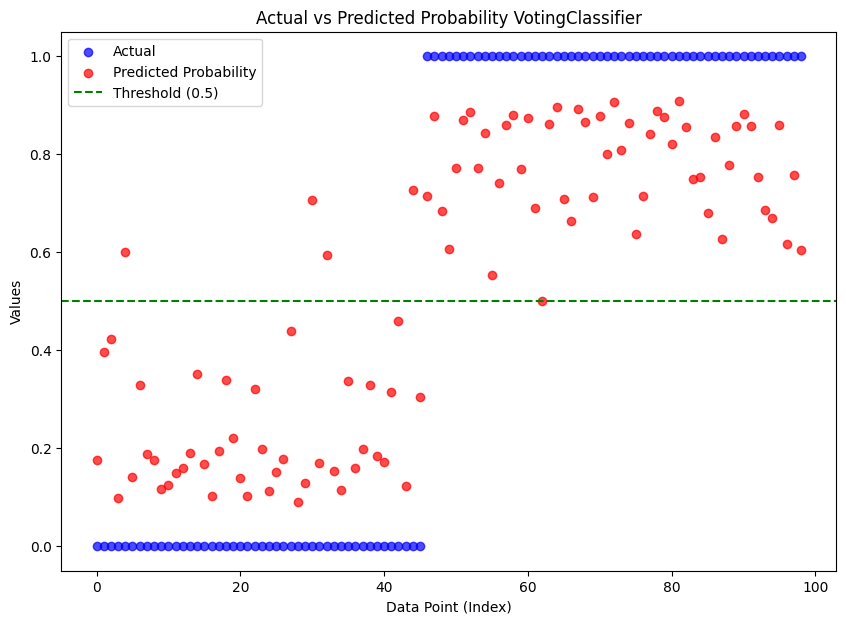

In [213]:
predicted_vs_actual_plot(table_clf_soft)

Confusion Matrix - Voting Classifier
Classification Report - Voting Classifier
              precision    recall  f1-score   support

           1       0.93      1.00      0.96        53
           0       1.00      0.91      0.95        46

    accuracy                           0.96        99
   macro avg       0.96      0.96      0.96        99
weighted avg       0.96      0.96      0.96        99



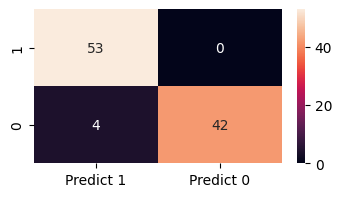

In [214]:
# Compute and print the confusion matrix
print("Confusion Matrix - Voting Classifier")
cm = confusion_matrix(y_test, y_predict_voting_cl, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4,2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Voting Classifier")
print(classification_report(y_test, y_predict_voting_cl, labels=[1, 0]))


save_metrics_finalDf('Voting Classifier - soft', y_test, y_predict_voting_cl)
save_model(model_voting, 'voting')


# Final Results

In [215]:
(final_results_df)

,accuracy,precision,recall,f1-score
PLDA (HPT),0.79,0.79,0.79,0.79
Logistic Regression (HPT),0.98,0.98,0.98,0.98
KNN (HPT),0.80,0.80,0.80,0.80
NB,0.68,0.69,0.68,0.68
SVM (HPT),0.99,0.99,0.99,0.99
Random Forest (HPT),0.88,0.88,0.88,0.88
Bagging (HPT),0.90,0.90,0.90,0.90
AdaBoost (HPT),0.87,0.88,0.87,0.87
XGBoost (HPT),0.91,0.91,0.91,0.91
Voting Classifier - soft,0.96,0.96,0.96,0.96


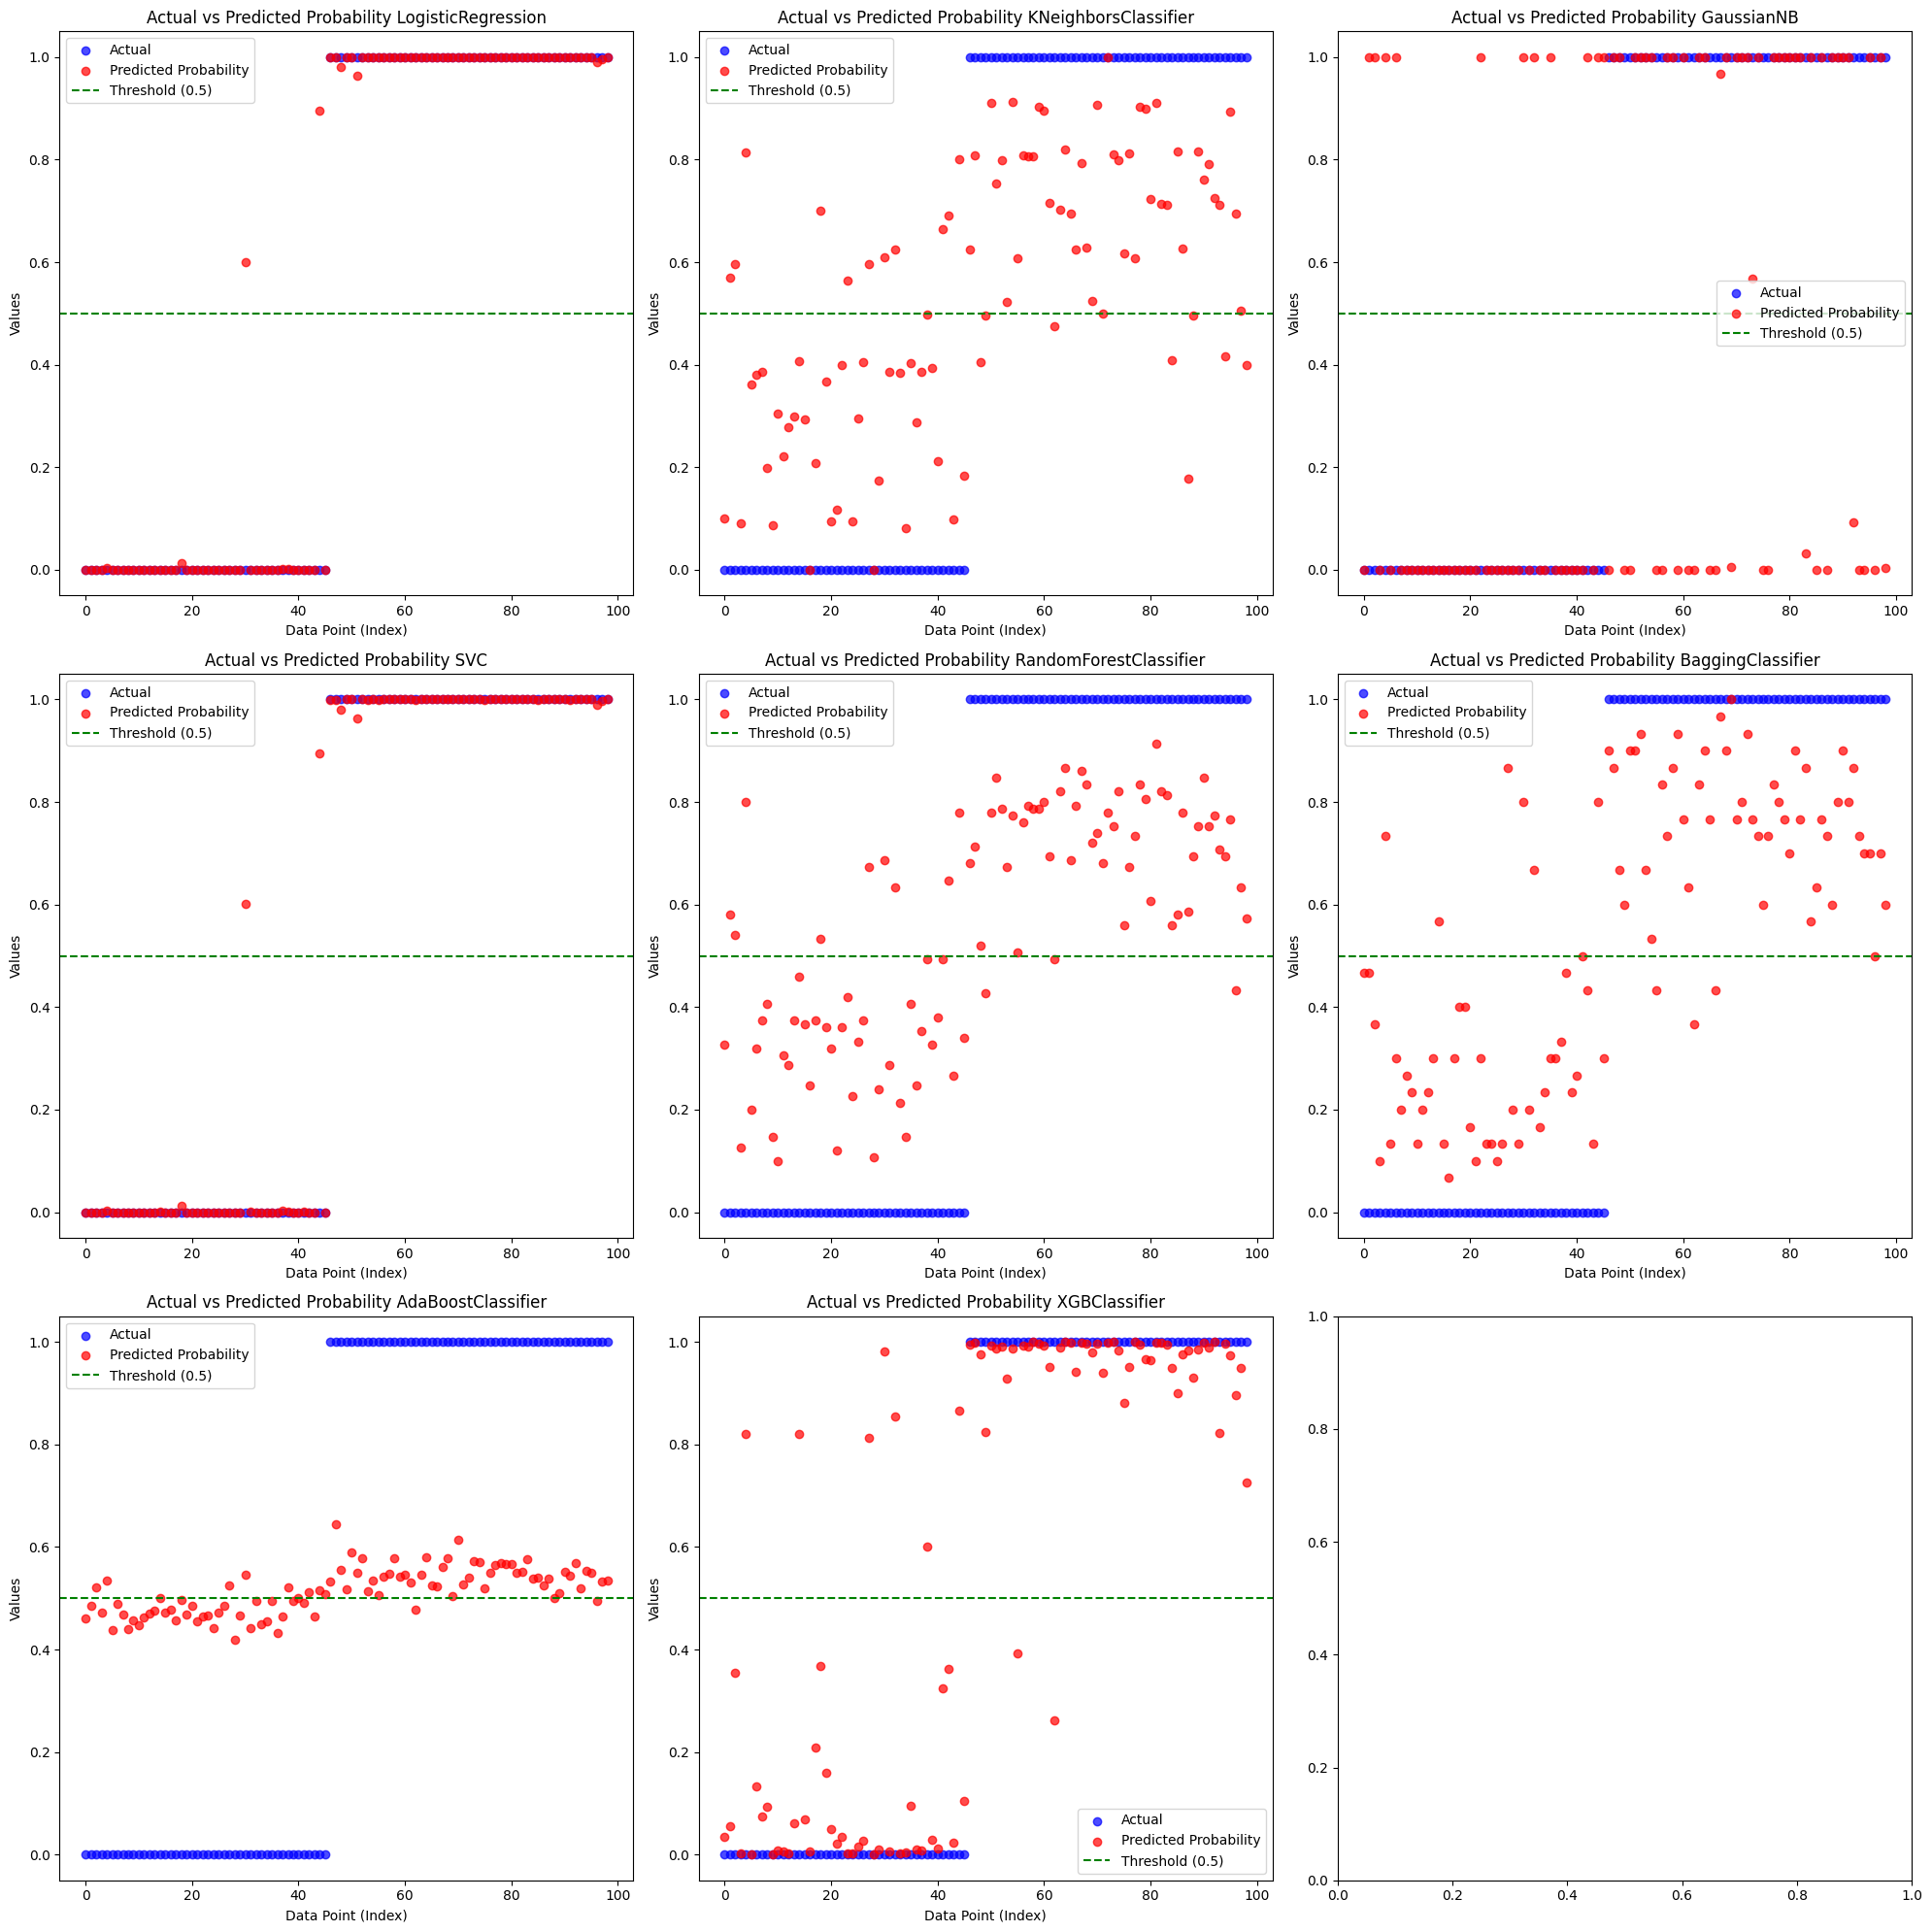

In [216]:

def PVASubplot(comparison_df, ax):
    # Sort the DataFrame by the 'Actual' column
    model_name = comparison_df.Name
    sorted_df = comparison_df.sort_values(by='Actual')

    # Scatter plot of Actual vs Predicted Probability
    ax.scatter(range(len(sorted_df)), sorted_df['Actual'], label='Actual', color='blue', alpha=0.7)
    ax.scatter(range(len(sorted_df)), sorted_df['Predicted_Probability'], label='Predicted Probability', color='red', alpha=0.7)

    # Draw a horizontal line at y=0.5
    ax.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

    ax.set_xlabel('Data Point (Index)')
    ax.set_ylabel('Values')
    ax.set_title('Actual vs Predicted Probability ' + model_name)
    ax.legend()


all_models_df = [table_lr_2, table_knn_2, table_nb, table_svm_2, table_rf, table_bgcl_2, table_adabc_2, table_xgbc_2]

rows = 3
cols = 3

# Create a subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))

for i in range(len(all_models_df)):
    PVASubplot(all_models_df[i], axes[i//cols][i%rows])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
